<a href="https://colab.research.google.com/github/yjyuwisely/Bigdata-project/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [ ]:
# 1. Load data
df = pd.read_csv("dataset_with_p_final_human.csv")

# Target / Features (drop leakage cols)
y = df['human'].astype(int)
X = df.drop(columns=['human', 'p_text_human', 'p_final_human', 'flagged'], errors='ignore')


In [ ]:
# 2. Preprocess (OHE categorical + scale numeric)
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

Xp = pre.fit_transform(X)


In [ ]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    Xp, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# 4. Baseline Logistic Regression (L2)
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000, random_state=42)
logreg_l2.fit(X_train, y_train)

print("=== Logistic Regression (L2) ===")
print(classification_report(y_test, logreg_l2.predict(X_test), digits=3))
print(confusion_matrix(y_test, logreg_l2.predict(X_test)))

cv_f1 = cross_val_score(logreg_l2, X_train, y_train, cv=5, scoring="f1").mean()
print("5-fold CV F1 (train split):", round(cv_f1, 3))


=== Logistic Regression (L2) ===
              precision    recall  f1-score   support

           0      0.669     0.282     0.397      1186
           1      0.739     0.935     0.826      2572

    accuracy                          0.729      3758
   macro avg      0.704     0.609     0.611      3758
weighted avg      0.717     0.729     0.690      3758

[[ 335  851]
 [ 166 2406]]
5-fold CV F1 (train split): 0.831


In [ ]:
# 5. Logistic Regression (L1 - feature selection)
logreg_l1 = LogisticRegression(
    penalty="l1", solver="saga", max_iter=4000, random_state=42, n_jobs=-1
)
logreg_l1.fit(X_train, y_train)

print("=== Logistic Regression (L1) ===")
print(classification_report(y_test, logreg_l1.predict(X_test), digits=3))
print(confusion_matrix(y_test, logreg_l1.predict(X_test)))


=== Logistic Regression (L1) ===
              precision    recall  f1-score   support

           0      0.669     0.285     0.400      1186
           1      0.739     0.935     0.826      2572

    accuracy                          0.730      3758
   macro avg      0.704     0.610     0.613      3758
weighted avg      0.717     0.730     0.691      3758

[[ 338  848]
 [ 167 2405]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


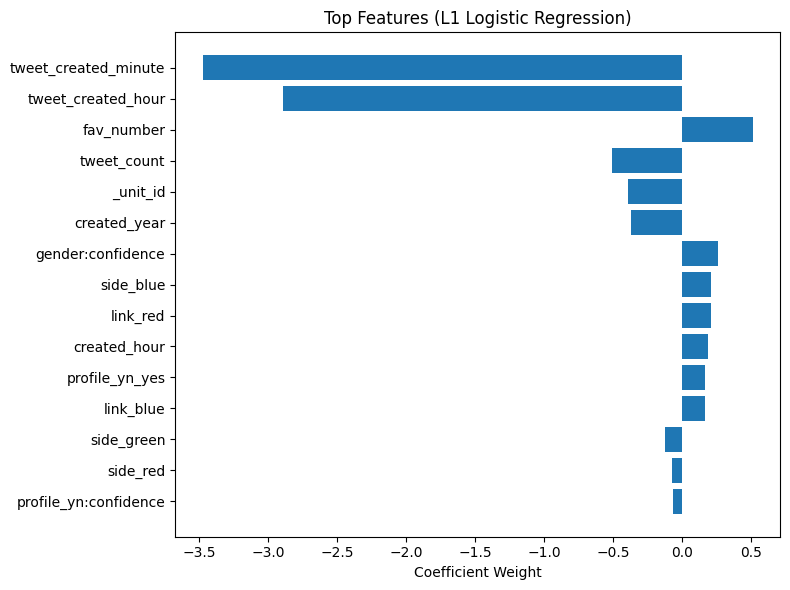

In [ ]:
# 6. Feature importance (L1 sparsity)
ohe = pre.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
num_feature_names = np.array(num_cols)
feature_names = np.concatenate([cat_feature_names, num_feature_names])

coefs = logreg_l1.coef_.ravel()
nonzero_idx = np.flatnonzero(coefs)

kept_features = feature_names[nonzero_idx]
kept_coefs = coefs[nonzero_idx]

top_idx = np.argsort(np.abs(kept_coefs))[-15:]

plt.figure(figsize=(8,6))
plt.barh(kept_features[top_idx], kept_coefs[top_idx])
plt.title("Top Features (L1 Logistic Regression)")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()


In [ ]:
# Top positive / negative drivers (toward human vs non-human)
top_k = 15
pos_idx = np.argsort(-kept_coefs)[:top_k]
neg_idx = np.argsort(kept_coefs)[:top_k]

print("\nTop positive features (push toward human):")
for f, w in zip(kept_features[pos_idx], kept_coefs[pos_idx]):
    print(f"{f:50s}  {w:+.3f}")

print("\nTop negative features (push toward non-human):")
for f, w in zip(kept_features[neg_idx], kept_coefs[neg_idx]):
    print(f"{f:50s}  {w:+.3f}")



Top positive features (push toward human):
fav_number                                          +0.510
gender:confidence                                   +0.256
side_blue                                           +0.212
link_red                                            +0.206
created_hour                                        +0.184
profile_yn_yes                                      +0.164
link_blue                                           +0.163
created_month                                       +0.013
created_day                                         +0.009
created_minute                                      -0.025
retweet_count                                       -0.032
link_green                                          -0.050
profile_yn:confidence                               -0.067
side_red                                            -0.072
side_green                                          -0.127

Top negative features (push toward non-human):
tweet_created_minute   

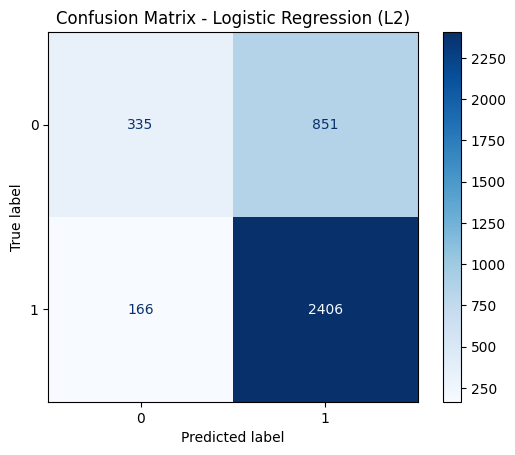

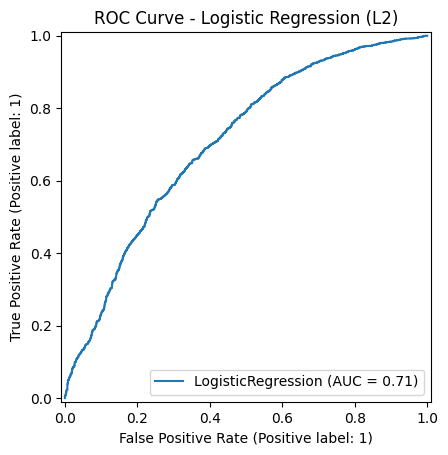

In [ ]:
# 7. Visualisations for L2
ConfusionMatrixDisplay.from_estimator(logreg_l2, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (L2)")
plt.show()

RocCurveDisplay.from_estimator(logreg_l2, X_test, y_test)
plt.title("ROC Curve - Logistic Regression (L2)")
plt.show()
